In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from scipy.special import softmax

from timeit import default_timer as timer
import random
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from tf_keras_vis.utils.callbacks import Print
# tf.compat.v1.disable_eager_execution()

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
#import vis.visualization
from tf_keras_vis.activation_maximization import ActivationMaximization

from tensorflow.python.framework import ops

import json
import pickle
import os
import sys
sys.path.append("../python/")
from helpers import *
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [2]:
# Globals
NUM_CHANNELS = 1
RESOLUTION_LIST = [128] # 64, 128] #, 224, 384]
SCENARIO_LIST = ["PrPo_Im"] #, "Pr_Im", "Pr_PoIm", "Pr_Po_Im"]
NUM_EPOCHS = 20
SAVED_MODEL_DIR = '../../results/models/'
MODEL_PERFORMANCE_METRICS_DIR = '../../results/model-performance/'
FULL_MODEL_PATH = '../../results/models/opt-cnn-PrPo_Im-128-px/model'

In [3]:
## these can also be globally set.
trial_seed = 1
image_sets = createResolutionScenarioImageDict(RESOLUTION_LIST, SCENARIO_LIST)

In [4]:
m = models.load_model(FULL_MODEL_PATH)

Why do we have two functions named "grad_cam"? If one is just an example from elsewhere, please comment it out.

In [8]:
# def grad_cam(input_model, image, cls, layer_name):
#     """GradCAM method for visualizing input saliency."""
#     y_c = input_model.output[0, cls]
#     conv_output = input_model.get_layer(layer_name).output
#     grads = K.gradients(y_c, conv_output)[0]
#     # Normalize if necessary
#     # grads = normalize(grads)
#     gradient_function = K.function([input_model.input], [conv_output, grads])

#     output, grads_val = gradient_function([image])
#     output, grads_val = output[0, :], grads_val[0, :, :, :]

#     weights = np.mean(grads_val, axis=(0, 1))
#     cam = np.dot(output, weights)

#     # Process CAM
#     cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
#     cam = np.maximum(cam, 0)
#     cam = cam / cam.max()
#     return cam

In the `grad_cam` function, update all variable names.

In [5]:
# Replaced all list identifies (i.e. cam_list) with variables indicating single image usage.
def grad_cam(index): 
    #     ALT: use train_test_split
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    
    #assert validation_labels[index].mean(axis=0)[0] == 0 ## This will throw an error for an image in the 1 class. Elaborate on it or comment out.
    cam_img = index # class activation map corresponds to the specified image index 
    class_labels = getClassLabels("PrPo_Im")
    print("Observed image class: ", class_labels[np.argmax(validation_labels[cam_img])])
    
    def loss(output):
        """Returns score corresponding to class of given image index"""                                       
        print("Loss output: ", output) ##
        loss_list = [output[i][j] for i, j in enumerate([np.argmax(j) for j in validation_labels[cam_img] ])]
        print(loss_list)
        print([softmax(loss) for loss in output.numpy()])
        return loss_list

    # Model_modifier function required for gradcam
    def model_modifier(model):
        """Remove softmax activation of last layer in model"""
        model.layers[-1].activation = tf.keras.activations.linear ## What does this do? put a note
        return model
    
    gradcam_image = validation_images[cam_img]
    gradcam = Gradcam(m, model_modifier = model_modifier)
    cam = gradcam(loss, gradcam_image, penultimate_layer = -1) ## What does `penultimate_layer` do? Check github to see if option is still active
    cam = normalize(cam)
    cam = np.squeeze(cam) # replace np.squeeze 
    print("Shape of heatmap matrix:", cam.shape )
    return cam, gradcam_image

Testing multiple PrPo images

In [6]:
gcam21 = grad_cam([21])
gcam36 = grad_cam([36])
gcam81 = grad_cam([81])
gcam107 = grad_cam([107])
gcam154 = grad_cam([154])

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[ 1.5553964 -3.4224868]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=1.5553964>]
[array([0.99315846, 0.0068415 ], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[2.1902301  0.13688846]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2.1902301>]
[array([0.8862849 , 0.11371517], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[ 2.5854983 -2.7722044]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2.5854983>]
[array([0.99531037, 0.00468962], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[0.5064118 1.5349969]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.5064118>]
[array([0.2633585, 0.7366415], dtype=fl

In [6]:
grad_cam([180])

Observed image class:  Improbable
Loss output:  tf.Tensor([[-5.9293814  6.7700357]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=6.7700357>]
[array([3.0528959e-06, 9.9999714e-01], dtype=float32)]
Shape of heatmap matrix: (128, 128)


(array([[0.43412858, 0.4355876 , 0.43973613, ..., 0.37266687, 0.36662602,
         0.36455438],
        [0.42981687, 0.43125325, 0.43534768, ..., 0.3734849 , 0.36746478,
         0.36540198],
        [0.41831145, 0.41968694, 0.42363632, ..., 0.37590316, 0.36990443,
         0.3678525 ],
        ...,
        [0.00522461, 0.00791176, 0.01542765, ..., 0.07545757, 0.06172598,
         0.05679033],
        [0.00692823, 0.00969556, 0.01742836, ..., 0.06517486, 0.05171213,
         0.04688491],
        [0.00762745, 0.01042197, 0.01822827, ..., 0.06138461, 0.04802742,
         0.04324253]], dtype=float32),
 array([[[[0.65882353],
          [0.84705882],
          [1.        ],
          ...,
          [0.99215686],
          [0.98823529],
          [0.98823529]],
 
         [[0.87843137],
          [0.65882353],
          [0.74509804],
          ...,
          [0.98823529],
          [0.98823529],
          [0.99215686]],
 
         [[1.        ],
          [0.94901961],
          [0.70980392]

In [6]:
# Saving GCAM objects of validation images before disabling eager execution
gcam10 = grad_cam([10])
gcam14 = grad_cam([14])
gcam5 = grad_cam([5])
gcam54 = grad_cam([54])
gcam101 = grad_cam([101])
gcam18  = grad_cam([18])
gcam180 = grad_cam([180])
gcam212 = grad_cam([212])
gcam184 = grad_cam([184])

Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[-0.60796046  0.7700536 ]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=-0.60796046>]
[array([0.20132813, 0.79867184], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[3.1717558  0.03628068]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=3.1717558>]
[array([0.95833266, 0.04166743], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[0.67535 1.54159]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.67535>]
[array([0.2960373 , 0.70396274], dtype=float32)]
Shape of heatmap matrix: (128, 128)
Observed image class:  Probable/Possible
Loss output:  tf.Tensor([[ 1.6081288 -1.5714568]], shape=(1, 2), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=1.6081288>]
[array([0.9600588 , 0.03994122], dtype=fl

In [7]:
# Save GCAM objects in a list to easily iterate over
# gcam_list = [gcam10, gcam14, gcam5, gcam53, gcam101, gcam18, gcam180, gcam212, gcam184]
gcam_list_prpo = [gcam21, gcam36, gcam81, gcam107, gcam154]

In [8]:
# Disable eager execution (GBP requirement)
# WARNING: kernel has to be restarted for GCAM to be called again.
# Replace Keras backed gradient with Gradient Tape for a permanent solution.
tf.compat.v1.disable_eager_execution()

def guided_backprop(index, prpo=False):#101
    #     ALT: use train_test_split
    training_images,validation_images,training_labels,validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    
    class_labels = getClassLabels("PrPo_Im")
    if prpo == True:
        assert validation_labels[index].mean(axis=0)[1] == 0
    else:
        assert validation_labels[index].mean(axis=0)[0] == 0
    cam_list = index
    
    backprop_images = validation_images[cam_list]
    
    def register_gradient():
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * tf.cast(op.inputs[0] > 0., dtype)

    def modify_backprop(model, name, monochrome=True):
        g = tf.compat.v1.get_default_graph()
        with g.gradient_override_map({'Relu': name}):

            # get layers that have an activation
            layer_dict = [layer for layer in model.layers[1:]
                          if hasattr(layer, 'activation')]

            # replace relu activation
            for layer in layer_dict:
                if layer.activation == tf.keras.activations.relu:
                    layer.activation = tf.nn.relu

            # re-instanciate a new model
            new_model = models.load_model(FULL_MODEL_PATH)
            
        return new_model

    def guided_backpropagation(img_tensor, model, activation_layer):
        model_input = model.input
        layer_output = model.get_layer(activation_layer).output

        max_output = K.max(layer_output, axis=3)
        
        get_output = K.function([model_input], [K.gradients(max_output, model_input)[0]])
        print("Gradient length: ",len(K.gradients(max_output, model_input)))
        saliency = get_output([img_tensor])
        print(saliency[0])
        
        return saliency[0]
    
    register_gradient()
    guided_model = modify_backprop(m, 'GuidedBackProp')
    gradient = guided_backpropagation(backprop_images, guided_model, 'conv2d_4')
#     print()
    gradient_sq = np.squeeze(gradient[0], axis=2)
    print("Shape of heatmap matrix:", gradient_sq.shape)
    
    return gradient_sq, index

In [21]:
def guided_backprop_gt(index):#101
    ## Original implementation: https://gist.github.com/you359/d19449a1c64bb43519a11e5d9d430453
    training_images, validation_images, training_labels, validation_labels =  train_test_split(np.array([np.expand_dims(x[0],axis=2) for x in image_sets[128]["PrPo_Im"]]), 
                np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), stratify= np.array([x[1] for x in image_sets[128]["PrPo_Im"]]), test_size=.2, random_state = trial_seed)
    
    class_labels = getClassLabels("PrPo_Im")
    # assert validation_labels[index].mean(axis=0)[0] == 0 ## only makes sense for class 0 images; otherwise, assert validation_labels[index].mean(axis=0)[1]
    cam_list = index
    
    backprop_images = validation_images[cam_list]
    
    def register_gradient(): ## modifies gradient to mask negative activations and gradients (guided signal)
        if "GuidedBackProp" not in ops._gradient_registry._registry:
            @ops.RegisterGradient("GuidedBackProp")
            def _GuidedBackProp(op, grad):
                dtype = op.inputs[0].dtype
                return grad * tf.cast(grad > 0., dtype) * tf.cast(op.inputs[0] > 0., dtype) ## See Fig1c of Springenberg et al., 2015 (p. 8)

    def modify_backprop(model, name, monochrome=True): 
        g = tf.compat.v1.get_default_graph()
        with g.gradient_override_map({'Relu': name}): ## update activation of ReLu
            # get layers that have an activation
            layer_dict = [layer for layer in model.layers[1:] if hasattr(layer, 'activation')]
            # replace relu activation
            for layer in layer_dict:
                if layer.activation == tf.keras.activations.relu:
                    layer.activation = tf.nn.relu
            # re-instantiate a new model
            new_model = models.load_model(FULL_MODEL_PATH)            
        return new_model

    #normalize saliency
    def guided_backpropagation(input_image, model, activation_layer):
        model_input = model.input
        print(model_input.shape)
        layer_output = model.get_layer(activation_layer).output
        print("Layer output shape: ", layer_output.shape)
        max_output = K.max(layer_output, axis=3) ## gets activation in layer of interest with greatest outputs (this what guided backprop does)
            ## in gbp, we visualize the part of the image that gives the greatest activation, hence this operation.
        print(max_output.shape) ## You should have commented on what the shapes are.
        
#         get_output = K.function([model_input], [K.gradients(max_output, model_input)[0]])
        
        ## May not ever work: https://github.com/tensorflow/tensorflow/issues/46194#issuecomment-827036146
        with tf.GradientTape() as tape: # attempt at replacing keras backend gradients
            model_input = model.input
            layer_output = model.get_layer(activation_layer).output
            max_output = K.max(layer_output, axis=3)
            grads = tape.gradient(max_output, model_input)[0] # TypeError: 'NoneType' object is not subscriptable
            print(grads.shape)            
            #get_output = K.function([model_input], [grads])

        #intermediate_layer_model = models.Model(inputs = model_input, outputs = grads)
        #intermediate_output = intermediate_layer_model.predict(input_image)
        #print(intermediate_output.shape) 
        # saliency = normalize(saliency) ## may not be necessary; actually it isn't
        # saliency = get_output([input_image])
        saliency = grads
        return saliency #saliency[0]
    
    register_gradient()
    guided_model = modify_backprop(m, 'GuidedBackProp')
    gradient = guided_backpropagation(backprop_images, guided_model, 'conv2d_4')
    
    return gradient, index

In [22]:
guided_backprop_gt([101])

(None, 128, 128, 1)
Layer output shape:  (None, 16, 16, 256)
(None, 16, 16)


AttributeError: 'KerasTensor' object has no attribute '_id'

In [9]:
gbp10 = guided_backprop([10], True)
gbp14 = guided_backprop([14], True)
gbp5  = guided_backprop([5], True)
gbp54 = guided_backprop([54], True)
gbp101 = guided_backprop([101])
gbp18  = guided_backprop([18])
gbp180 = guided_backprop([180])
gbp212 = guided_backprop([212])
gbp184 = guided_backprop([184])

Gradient length:  1
[[[[ 7.2392570e-05]
   [ 2.5474415e-03]
   [ 4.9485648e-03]
   ...
   [ 1.3451664e-03]
   [ 3.9493102e-03]
   [ 5.1806108e-03]]

  [[-1.3817287e-03]
   [ 1.2401524e-02]
   [ 7.8819748e-03]
   ...
   [ 2.3015298e-02]
   [ 1.1707553e-02]
   [ 1.3301954e-02]]

  [[ 2.8278562e-05]
   [ 1.1193462e-02]
   [ 3.1373857e-03]
   ...
   [ 1.4321521e-02]
   [ 1.7865403e-03]
   [ 1.0393645e-02]]

  ...

  [[ 1.0159332e-04]
   [ 1.4500004e-02]
   [ 6.5448829e-03]
   ...
   [ 1.1097193e-02]
   [ 3.0972837e-03]
   [ 1.1308988e-02]]

  [[ 1.2158646e-03]
   [ 2.2337826e-03]
   [ 2.1434003e-03]
   ...
   [ 4.7493698e-03]
   [ 2.5346694e-03]
   [ 4.8702783e-03]]

  [[ 2.9592824e-03]
   [ 8.8329399e-03]
   [ 3.7022936e-03]
   ...
   [ 8.8745328e-03]
   [ 3.4405072e-03]
   [ 4.2610681e-03]]]]
Shape of heatmap matrix: (128, 128)
Gradient length:  1
[[[[ 0.000765  ]
   [ 0.00104966]
   [ 0.00317673]
   ...
   [-0.00076815]
   [ 0.00086389]
   [ 0.00179257]]

  [[-0.00168621]
   [ 0.0076795

In [26]:
gbp101 = guided_backprop([101])

Gradient length:  1
[[[[ 0.00078276]
   [ 0.00158801]
   [ 0.00218869]
   ...
   [ 0.00227443]
   [ 0.00229405]
   [ 0.00293886]]

  [[-0.00129388]
   [ 0.00819799]
   [ 0.00800379]
   ...
   [ 0.01349041]
   [ 0.00719786]
   [ 0.00643284]]

  [[-0.00017844]
   [ 0.00557406]
   [ 0.00375208]
   ...
   [ 0.00781585]
   [-0.00068772]
   [ 0.00439347]]

  ...

  [[-0.00226742]
   [ 0.01518545]
   [ 0.0040855 ]
   ...
   [ 0.00394544]
   [-0.00021767]
   [ 0.00622715]]

  [[ 0.00151458]
   [ 0.00420545]
   [ 0.00502296]
   ...
   [ 0.00226174]
   [ 0.00298391]
   [ 0.00417192]]

  [[ 0.00319271]
   [ 0.00802812]
   [-0.00247717]
   ...
   [ 0.00798536]
   [ 0.01017314]
   [ 0.00966706]]]]
Shape of heatmap matrix: (128, 128)


In [ ]:
gcam21, gcam36, gcam81, gcam107, gcam154

In [10]:
gbp21 = guided_backprop([21], True)
gbp36 = guided_backprop([36], True)
gbp81  = guided_backprop([81], True)
gbp107 = guided_backprop([107], True)
gbp154 = guided_backprop([154], True)

Gradient length:  1
[[[[-0.00127409]
   [-0.00096585]
   [ 0.00298946]
   ...
   [ 0.00213112]
   [ 0.00286749]
   [ 0.00263953]]

  [[ 0.00050037]
   [ 0.00893932]
   [ 0.00865137]
   ...
   [ 0.01566176]
   [ 0.00874703]
   [ 0.0055433 ]]

  [[-0.00395532]
   [ 0.00481963]
   [ 0.00659049]
   ...
   [ 0.00946764]
   [ 0.00097301]
   [ 0.00401681]]

  ...

  [[ 0.00152763]
   [ 0.01564084]
   [-0.00485983]
   ...
   [ 0.01090682]
   [ 0.00212404]
   [ 0.00264846]]

  [[ 0.00030027]
   [ 0.00285904]
   [ 0.00455574]
   ...
   [ 0.00506769]
   [ 0.00259499]
   [ 0.00399299]]

  [[ 0.00438653]
   [ 0.002995  ]
   [-0.00413492]
   ...
   [ 0.00635054]
   [ 0.00810416]
   [ 0.0086301 ]]]]
Shape of heatmap matrix: (128, 128)
Gradient length:  1
[[[[-0.00062433]
   [ 0.00280687]
   [ 0.0037404 ]
   ...
   [ 0.00426991]
   [ 0.00206961]
   [ 0.00157976]]

  [[-0.00080901]
   [ 0.00676361]
   [ 0.00746796]
   ...
   [ 0.00626362]
   [ 0.00635986]
   [ 0.00626453]]

  [[ 0.00149356]
   [ 0.0047

In [11]:
# Save GBP objects in a list to easily iterate over
# gbp_list = [gbp101, gbp18, gbp180, gbp212, gbp184]
gbp_list_prpo = [gbp21, gbp36, gbp81, gbp107, gbp154]

In [12]:
def guided_gradcam(gcam, gbp, index, c_map='gist_gray'):
    # element-wise multiplication in Python
    # https://stackoverflow.com/questions/40034993/how-to-get-element-wise-matrix-multiplication-hadamard-product-in-numpy
    ggcam = gcam[0] * gbp[0]
#     ggcam = np.squeeze(ggcam[0])
    print('Shape of GGCAM: ', ggcam.shape)
    
    guided_gradcam = '../../figures/plottingGuided-GradCam/'
    if not os.path.exists(guided_gradcam):
        os.makedirs(guided_gradcam)
        
    plt.figure(figsize=(5, 5))
    plt.suptitle('Guided Grad-CAM')
    plt.title('Index ' + str(gbp[1]), y=-0.06)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(ggcam, cmap=c_map)
    plt.subplots_adjust(top=0.92)
    print(ggcam)
    plt.savefig(guided_gradcam+"guided-gradcam-index-"+str(index)+'-'+c_map+".png")
    plt.show()

Shape of GGCAM:  (128, 128)
[[-1.53660396e-04 -1.16484705e-04  3.60539940e-04 ...  2.57021515e-04
   3.45829845e-04  3.18337727e-04]
 [ 6.03471344e-05  1.07811636e-03  1.04338850e-03 ...  1.88886770e-03
   1.05492491e-03  6.68542983e-04]
 [-4.77026741e-04  5.81265602e-04  7.94838357e-04 ...  1.14183372e-03
   1.17349264e-04  4.84442280e-04]
 ...
 [ 1.84238423e-04  1.88634451e-03 -5.86113427e-04 ...  1.31540792e-03
   2.56167521e-04  3.19414830e-04]
 [ 3.62135725e-05  3.44811531e-04  5.49439981e-04 ...  6.11183175e-04
   3.12965887e-04  4.81569237e-04]
 [ 5.29031793e-04  3.61208338e-04 -4.98686626e-04 ...  7.65899022e-04
   9.77393007e-04  1.04082283e-03]]


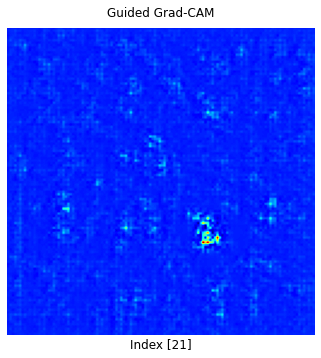

Shape of GGCAM:  (128, 128)
[[-0.  0.  0. ...  0.  0.  0.]
 [-0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [-0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. -0. ...  0.  0.  0.]]


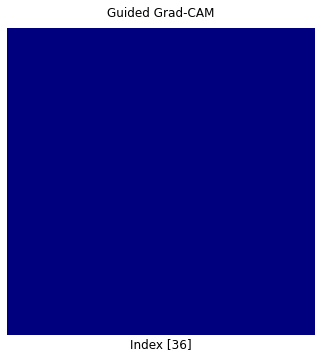

Shape of GGCAM:  (128, 128)
[[-1.8907351e-04 -2.7513219e-04  3.0681814e-04 ...  3.3144144e-04
   1.6060754e-04  2.0216050e-04]
 [ 4.1945084e-05  5.0566893e-04  4.2578971e-04 ...  6.9264148e-04
   4.1696860e-04  5.7458878e-04]
 [ 3.0545655e-04  8.2273176e-04  4.1818744e-04 ...  4.5527850e-04
  -1.7355796e-04  4.2724490e-04]
 ...
 [ 2.6382925e-04  5.8627670e-04  1.1770647e-04 ... -6.0565199e-05
   8.9647883e-04  1.1252583e-03]
 [-6.1242987e-05  5.8996835e-04  2.5779958e-04 ...  3.1289953e-04
   1.6689900e-04  7.0816645e-04]
 [ 6.2950619e-04  8.9938170e-04 -1.6498854e-04 ...  1.0387575e-03
   5.0648546e-04  8.6688442e-04]]


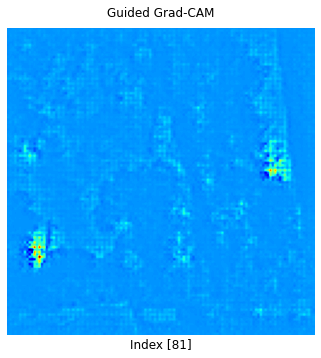

Shape of GGCAM:  (128, 128)
[[ 4.1153876e-06  1.6349385e-04  3.0174968e-04 ...  2.0263682e-04
   3.8438849e-04  3.6915860e-04]
 [-8.2387473e-05  9.6161221e-04  5.1725021e-04 ...  1.7727901e-03
   1.2865379e-03  7.6399755e-04]
 [ 1.0863303e-05  7.3781045e-04  3.4332211e-04 ...  1.6004224e-03
   1.0113677e-04  8.0619747e-04]
 ...
 [-2.9981456e-04 -2.0679367e-04 -2.9618081e-04 ...  8.8320521e-04
   2.1007381e-05  2.7793064e-04]
 [-5.3549005e-04  2.5808706e-04 -1.8455801e-04 ...  6.0080527e-04
   2.9067500e-04  3.1528983e-04]
 [-5.4565049e-04  3.6006866e-04  3.5840567e-04 ...  5.6804734e-04
   4.0957710e-04  5.2335794e-04]]


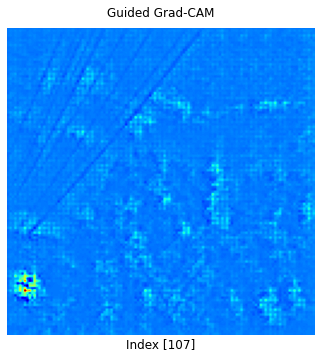

Shape of GGCAM:  (128, 128)
[[ 0.  0.  0. ...  0.  0. -0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. -0. ... -0. -0.  0.]
 ...
 [-0.  0. -0. ...  0.  0.  0.]
 [-0.  0.  0. ...  0.  0.  0.]
 [-0.  0.  0. ...  0.  0.  0.]]


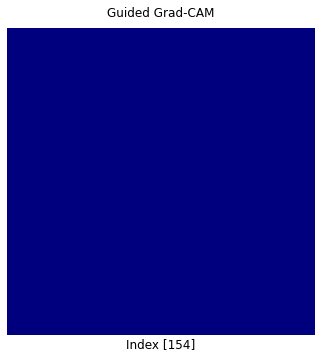

In [13]:
# Plot Guided-GCAM for 5 validation images
# Current implementation requires GCAM 
for i in range(len(gbp_list_prpo)):
    guided_gradcam(gcam_list_prpo[i], gbp_list_prpo[i], gbp_list_prpo[i][1], 'jet')

Shape of GGCAM:  (128, 128)
[[ 2.1273510e-04  4.4280596e-04  6.5266847e-04 ...  7.1462523e-04
   7.0655270e-04  8.9897256e-04]
 [-3.5340531e-04  2.2965665e-03  2.3957363e-03 ...  4.2719757e-03
   2.2349441e-03  1.9839553e-03]
 [-4.9440536e-05  1.5824323e-03  1.1354362e-03 ...  2.5293471e-03
  -2.1838064e-04  1.3860350e-03]
 ...
 [-3.4501660e-04  2.4055056e-03  7.1815058e-04 ...  7.0152147e-04
  -3.4968110e-05  9.6174475e-04]
 [ 2.2989961e-04  6.6426635e-04  8.7948510e-04 ...  3.6496783e-04
   4.2927510e-04  5.7377678e-04]
 [ 4.8442875e-04  1.2673235e-03 -4.3328328e-04 ...  1.2402084e-03
   1.4006083e-03  1.2692821e-03]]


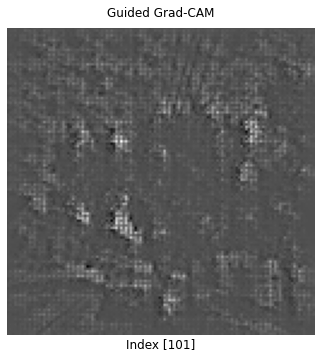

In [22]:
# Single Guided Gradcam Visualization
guided_gradcam(gcam101, gbp101, gbp101[1])

In [15]:
# Plot backpropagation using keras backend gradient
def plotBackprop(gbp, c_map = 'gist_gray'):
    plt.figure(figsize=(5, 5))
    plt.suptitle('Guided Backpropagation')
    plt.title('Index ' + str(gbp[1]), y=-0.06)
    plt.axis('off')
    plt.tight_layout()
#     norm_gbp = normalize(gbp[0]) # normalized gbp output
    plt.imshow(gbp[0], cmap=c_map)
    plt.subplots_adjust(top=0.92)
    print(gbp[0].shape)
    plt.savefig('../../figures/plottingBackProp/guided-backprop-index-'+str(gbp[1])+'-'+c_map+'.png')
    plt.show()

(128, 128)


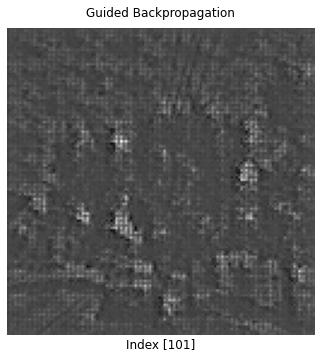

In [20]:
plotBackprop(gbp101)

(128, 128)


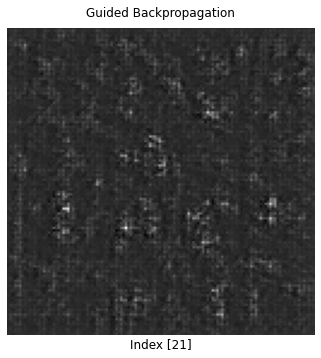

(128, 128)


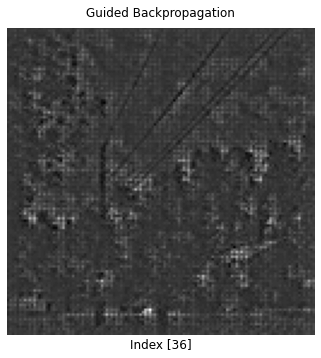

(128, 128)


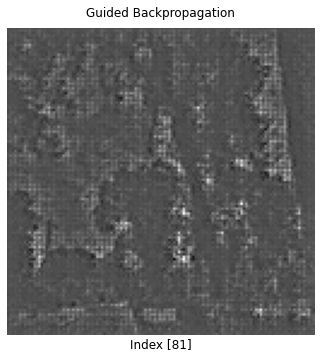

(128, 128)


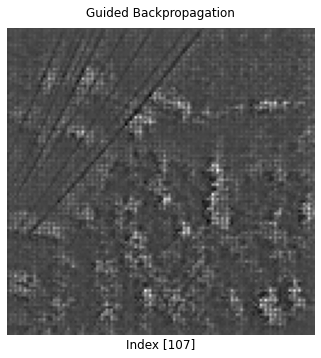

(128, 128)


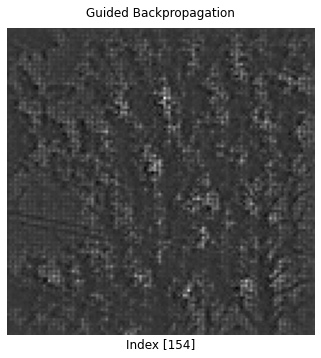

In [16]:
# Plot guided back propagation for all images in the GBP list
for i in range(len(gbp_list_prpo)):
    plotBackprop(gbp_list_prpo[i])